# 9.1. 门控循环单元（GRU）

在 8.7节中， 我们讨论了如何在循环神经网络中计算梯度， 以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。 下面我们简单思考一下这种梯度异常在实践中的意义：

- 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有非常重要的意义。 考虑一个极端情况，其中第一个观测值包含一个校验和， 目标是在序列的末尾辨别校验和是否正确。 在这种情况下，第一个词元的影响至关重要。 我们希望有某些机制能够在一个记忆元里存储重要的早期信息。 如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度， 因为它会影响所有后续的观测值。

- 我们可能会遇到这样的情况：一些词元没有相关的观测值。 例如，在对网页内容进行情感分析时， 可能有一些辅助HTML代码与网页传达的情绪无关。 我们希望有一些机制来跳过隐状态表示中的此类词元。

- 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。 例如，书的章节之间可能会有过渡存在， 或者证券的熊市和牛市之间可能会有过渡存在。 在这种情况下，最好有一种方法来重置我们的内部状态表示。

在学术界已经提出了许多方法来解决这类问题。 其中最早的方法是”长短期记忆”（long-short-term memory，LSTM） (Hochreiter and Schmidhuber, 1997)， 我们将在 9.2节中讨论。 门控循环单元（gated recurrent unit，GRU） (Cho et al., 2014) 是一个稍微简化的变体，通常能够提供同等的效果， 并且计算 (Chung et al., 2014)的速度明显更快。 由于门控循环单元更简单，我们从它开始解读。

# 9.1.1. 门控隐状态

门控循环单元与普通的循环神经网络之间的关键区别在于： 前者支持隐状态的门控。 这意味着模型有专门的机制来确定应该何时**更新**隐状态， 以及应该何时**重置**隐状态。

## 9.1.1.1. 重置门和更新门

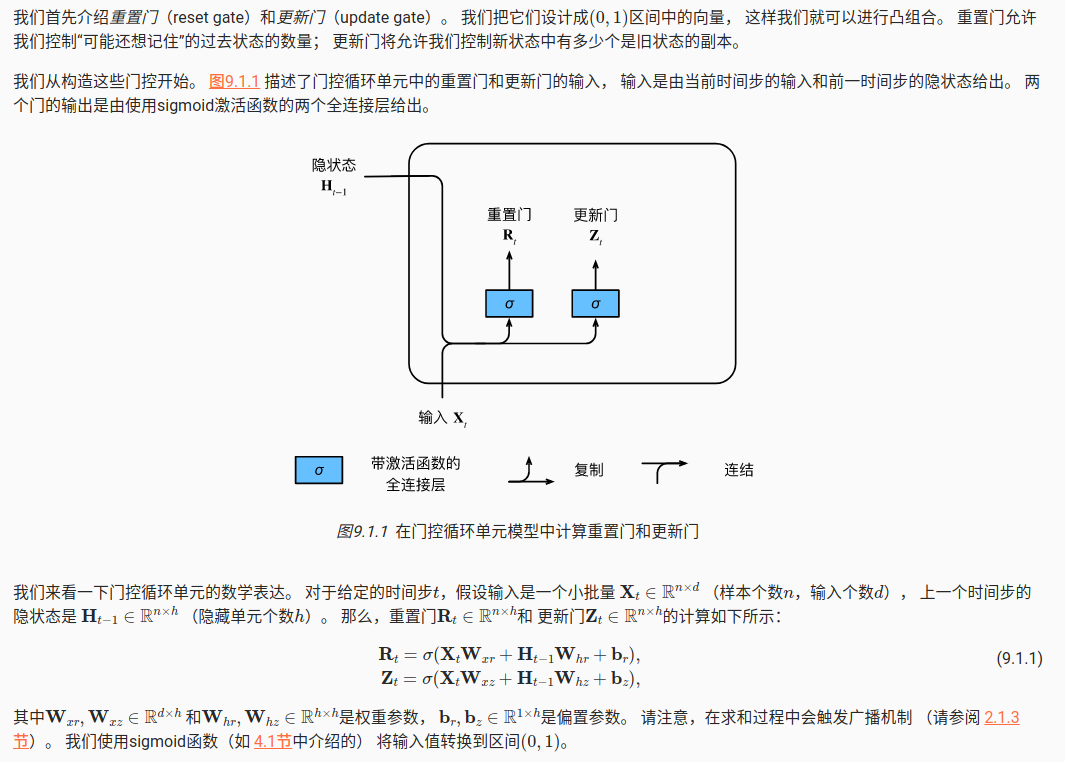

## 9.1.1.2. 候选隐状态

候选隐状态：经过重置门影响Ht-1后的输出，形式与普通隐状态类似，但Ht-1与重置门输出Rt点乘，Rt为1的影响不大，为0的n部分不再受Ht-1影响

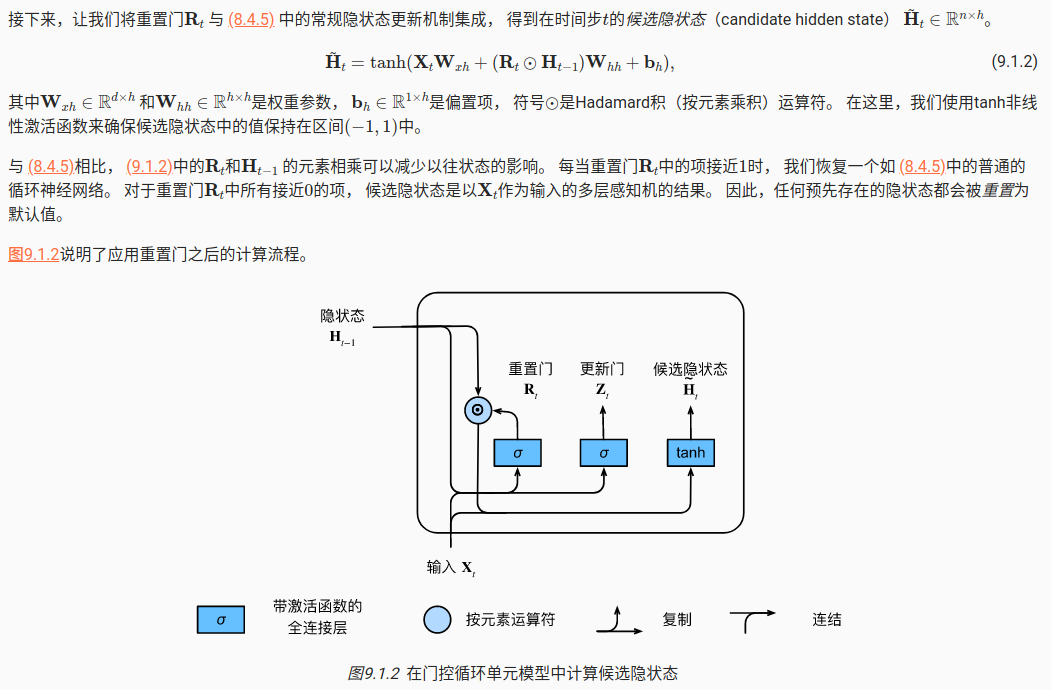

## 9.1.1.3. 隐状态

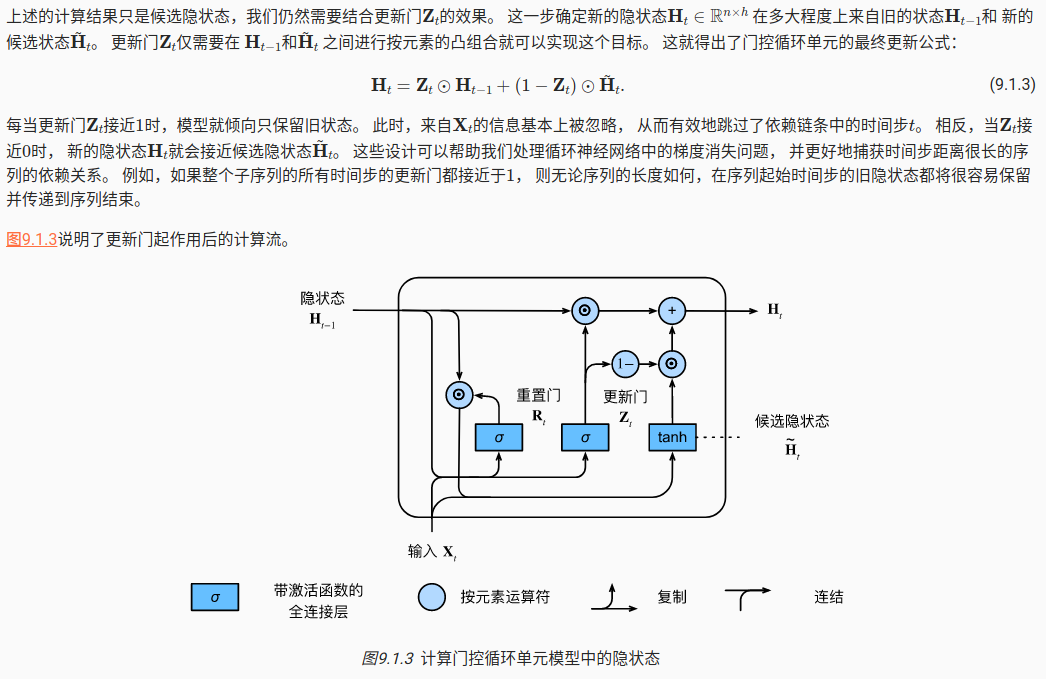

总之，门控循环单元具有以下两个显著特征：

- 重置门有助于捕获序列中的短期依赖关系；

- 更新门有助于捕获序列中的长期依赖关系。

# 9.1.2. 从零开始实现

参照8.5中的循环神经网络实现，一个手写循环神经网络的主要函数和类有：
> 1. **函数**：初始化模型参数。包括隐藏层更新参数和输出层参数  
def get_params(vocab_size, num_hiddens, device):  
    return params

> 2. **函数**：初始化时返回隐状态变量。这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）  
def init_rnn_state(batch_size, num_hiddens, device):  
    return (torch.zeros((batch_size, num_hiddens), device=device), )

> 3. **函数**：网络前向传播。返回输出和隐变量  
def rnn(inputs, state, params):  
    return torch.cat(outputs, dim=0), (H,)

> 4. **类**：RNNModelScratch类。连接前面的函数  
class RNNModelScratch:  
    def \_\_init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):  
    def \_\_call__(self, X, state):  
    def begin_state(self, batch_size, device):  


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 9.1.2.1. 初始化模型参数

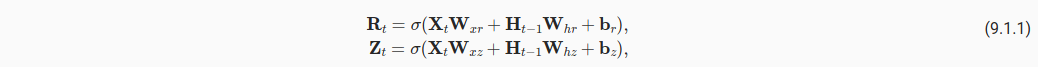
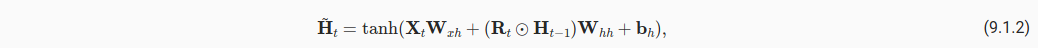
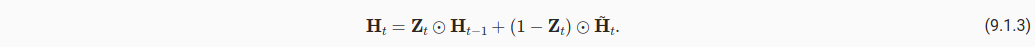

In [3]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数：前面都是更新H的，还需要输出Y=[Ht * W_hq + b_q]
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 9.1.2.2. 定义模型

In [4]:
# 在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros(size=(batch_size, num_hiddens), device=device), )

In [5]:
# 前向函数
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

RNNModelScratch类。连接前面的函数，用前面的就可以

## 9.1.2.3. 训练与预测

perplexity 1.1, 40527.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


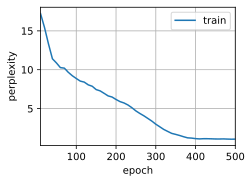

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 9.1.3. 简洁实现

8.6中实现了简洁的RNNModel类：循环神经网络模型，只需要rnn_layer和vocab_size

perplexity 1.0, 319925.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


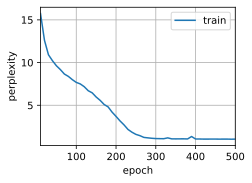

In [7]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 9.1.4. 小结

- 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。

- 重置门有助于捕获序列中的短期依赖关系。

- 更新门有助于捕获序列中的长期依赖关系。

- 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。

# 9.1.5. 练习